# GUMDPs: Policy optimization in the finite trials regime

Notebook containing the experiments for the FrozenLake and Taxi environments.

In [ ]:
# A valid Gurobi license is needed (https://www.gurobi.com/).
# GUROBI_OPTIONS = {
#    "WLSACCESSID": ,
#    "WLSSECRET": ,
#    "LICENSEID": ,
#}

In [ ]:
import os
import math
import json
import itertools
import numpy as np
import matplotlib
import cvxpy as cp
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

from algos.optimistic_planning import OptimisticPlanning
from envs.envs_gym import get_gym_env, Occupancy_MDP_Gym, FROZEN_LAKE_D_BETA, PENDULUM_D_BETA, MOUNTAINCAR_D_BETA, TAXI_D_BETA

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

#### Auxiliary functions

In [2]:
def sample_trajectory(env, policy, traj_length):
    # Args:
    # env - environment.
    # policy - policy specification (np.array).
    # traj_length - length of the sampled trajectory.

    states = []
    actions = []

    s, _ = env.reset()

    for t in range(traj_length):
        states.append(s)

        a = np.random.choice(range(env.num_actions), p=policy[s])
        actions.append(a)

        s, _, _, _, _ = env.step(s, a)

    return states, actions

In [3]:
def estimate_d_pi_from_trajectory(env, trajectory_states, trajectory_actions, gamma):

    nS = env.num_states
    nA = env.num_actions

    d_hats = []
    d_hat = np.zeros((nS,nA))
    for t in range(len(trajectory_states)):
        s_t = trajectory_states[t]
        a_t = trajectory_actions[t]
        
        d_hat[s_t,a_t] += gamma**t * 1

        d_hats.append(((1 - gamma)/(1 - gamma**(t+1))) * d_hat)
        
    return np.array(d_hats)

In [4]:
def estimate_f_d_pi_from_samples(env, obj_f, gamma, policy, N, K, max_traj_length, flatten=False):
    
    nS = env.num_states
    nA = env.num_actions

    f_estimated_list = []
    for n in range(N):

        # Compute d_hat from K sampled trajectories.
        d_hat = np.zeros((max_traj_length,nS,nA))
        for k in range(K):
            traj_states, traj_actions = sample_trajectory(env, policy, traj_length=max_traj_length)
            d_hat += estimate_d_pi_from_trajectory(env, traj_states, traj_actions, gamma)
        d_hat = d_hat / K

        # Compute f(d_hat), d_hat.shape = [max_traj_length, nS, nA].
        if not flatten:
            f_d_hat = np.array([obj_f(x) for x in d_hat])
        else:
            f_d_hat = np.array([obj_f(x.flatten()) for x in d_hat])

        f_estimated_list.append(f_d_hat)

    return np.array(f_estimated_list) # [N, max_traj_length]

In [5]:
def mean_ci(samples: np.ndarray, num_resamples: int=25_000):
    # Point estimation.
    point_estimate = np.mean(samples)
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True)
    point_estimations = np.mean(resampled, axis=0)
    confidence_interval = [np.percentile(point_estimations, 5),
                           np.percentile(point_estimations, 95)]
    return confidence_interval

In [6]:
def construct_random_policy(nS, nA):
    pol = np.ones((nS, nA))
    return pol / np.sum(pol, axis=1, keepdims=True)
# print(construct_random_policy(nS=5, nA=3))

#### Infinite trials solver

In [16]:
def build_transition_matrix(env, num_samples=1_000):
    
    nS = env.num_states
    nA = env.num_actions
    P = np.zeros((nA, nS, nS))
    
    for action in range(nA):
        for state in range(nS):

            count_next_states = np.zeros(nS)
            for _ in range(num_samples):
                print(state)
                new_state, _, _, _, _  = env.step(state, action)
                count_next_states[new_state] += 1
            P[action,state,:] = count_next_states / np.sum(count_next_states)

    return P

def build_initial_states_distribution(env, num_samples=1_000):
    
    nS = env.num_states

    count_initial_states = np.zeros(nS)
    for _ in range(num_samples):
        initial_state, _ = env.reset()
        count_initial_states[initial_state] += 1
    p_0 = count_initial_states / np.sum(count_initial_states)

    return p_0
    
# env, obj_f = get_gym_env("pendulum_entropy")
# print("env.num_states", env.num_states)
# print("env.num_actions", env.num_actions)  
# P_sampled = build_transition_matrix(env)

In [8]:
def solve_cvx_opt_problem(env, obj_f, gamma):

    nS = env.num_states
    nA = env.num_actions

    print('Building transition matrix and initial states distribution...')
    P_matrix = build_transition_matrix(env)
    p_0 = build_initial_states_distribution(env)
    print("P_matrix.shape", P_matrix.shape)
    print("p_0.shape", p_0.shape)
    
    x = cp.Variable((nS, nA))
    
    constraints = []
    for s in range(nS):
        lhs = cp.sum(x[s, :])
        rhs = (1 - gamma) * p_0[s] + gamma * sum(
            cp.sum(cp.multiply(P_matrix[a][:, s], x[:, a])) for a in range(nA)
        )
        constraints.append(lhs == rhs)
    constraints.append(x >= 0.0)

    obj = obj_f(x)
    
    prob = cp.Problem(obj, constraints)
    prob.solve()

    # x.value[x.value < 0.0] = 1e-8 # TODO.
    # x.value += 1e-05 # TODO
    
    # print("status:", prob.status)
    # print("optimal value", prob.value)
    # print("optimal var", x.value)

    opt_policy = x.value / np.sum(x.value, axis=1, keepdims=True)

    return prob.value, opt_policy

#### Plotting functions

In [32]:
def plot_2(DATA_TO_PLOT, mdp_name):

    plt.figure(figsize=(5.0, 4.0))
    
    # Plot f(\hat{d}) of \pi_random.
    random_policy_f_data = DATA_TO_PLOT["random_policy_f"][:,-1]
    cis = mean_ci(random_policy_f_data)
    errors = np.array([np.mean(random_policy_f_data) - cis[0], cis[1] - np.mean(random_policy_f_data)]).reshape(-1,1)
    plt.errorbar(1, np.mean(random_policy_f_data), yerr=errors, capsize=3, fmt='o')

    print("pi_rand", np.mean(random_policy_f_data), "ci_low:", np.mean(random_policy_f_data) - cis[0], "ci_up:", cis[1] - np.mean(random_policy_f_data))

    # Plot f(\hat{d}) of \pi_\infty^*.
    infinite_trials_policy_f_data = DATA_TO_PLOT["infinite_trials_f"][:,-1]
    cis = mean_ci(infinite_trials_policy_f_data)
    errors = np.array([np.mean(infinite_trials_policy_f_data) - cis[0], cis[1] - np.mean(infinite_trials_policy_f_data)]).reshape(-1,1)
    plt.errorbar(2, np.mean(infinite_trials_policy_f_data), yerr=errors, capsize=3, fmt='o')

    print("pi_infinity", np.mean(infinite_trials_policy_f_data), "ci_low:", np.mean(infinite_trials_policy_f_data) - cis[0], "ci_up:", cis[1] - np.mean(infinite_trials_policy_f_data))
    
    # Plot f(\hat{d}) of MCTS policy.
    mcts_data = DATA_TO_PLOT["mcts_planner"]
    cis = mean_ci(mcts_data)
    errors = np.array([round(np.mean(mcts_data) - cis[0],4), round(cis[1] - np.mean(mcts_data),4)]).reshape(-1,1)
    plt.errorbar(3, np.mean(mcts_data), yerr=errors, capsize=3, fmt='o')

    print("pi_mcts", np.mean(mcts_data), "ci_low:", np.mean(mcts_data) - cis[0], "ci_up:", cis[1] - np.mean(mcts_data))
    
    # ax.set_ylim([-1.5,-0.2])
    plt.xticks([1,2,3], [r"$\pi = \pi_{Random}$", r"$\pi = \pi_\infty^*$", r"$\pi = \pi^*_{MCTS}$"])
    plt.grid()
    #plt.legend()

    plt.ylabel(r'$F_{1,H}(\pi)$')

    os.makedirs("figs/", exist_ok=True)
    plt.savefig(f'figs/{mdp_name}_plot2.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

In [10]:
def plot_3(DATA_TO_PLOT, mdp_name):

    plt.figure(figsize=(5.0, 4.0))
    # fig.tight_layout()
    
    # Plot f(\hat{d}) of \pi_random.
    random_policy_f_data = DATA_TO_PLOT["random_policy_f"][:,-1]
    plt.violinplot(random_policy_f_data, [1], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)
    
    # Plot f(\hat{d}) of \pi_\infty^*.
    infinite_trials_policy_f_data = DATA_TO_PLOT["infinite_trials_f"][:,-1]
    plt.violinplot(infinite_trials_policy_f_data, [2], widths=0.3,
                      showmeans=False, showmedians=True, showextrema=True)

    # Plot f(\hat{d}) of MCTS policy.
    mcts_data = DATA_TO_PLOT["mcts_planner"]
    plt.violinplot(mcts_data, [3], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)
    
    #ax.set_ylim([-0.01,1.01])
    # ax.set_title(r"$\gamma = $ " + str(gamma_val))
    #ax.set_xlabel(r'$H$')

    plt.grid()
    #ax.legend()
    plt.xticks([1,2,3], [r"$\pi = \pi_{Random}$", r"$\pi = \pi_\infty^*$", r"$\pi = \pi^*_{MCTS}$"])

    plt.ylabel(r'$F_{1,H}(\pi)$')
    
    os.makedirs("figs/", exist_ok=True)
    plt.savefig(f'figs/{mdp_name}_plot3.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

## Entropy maximization

#### The objective function is $f(d) = d^\top \log(d) = - \mathcal{H}(d)$

In [9]:
def compute_infinite_trials_objective_entropy(env, obj_f, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)
    
    # Define objective function.
    cvx_obj_f = lambda x: cp.Minimize(-cp.sum(cp.entr(x))) # (Minus) entropy function.
    x_star, opt_policy_infinite_trials = solve_cvx_opt_problem(env, cvx_obj_f, gamma)
    # print("np.sum(opt_policy_infinite_trials)", np.sum(opt_policy_infinite_trials))
    # print("opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)]", opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)])
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, opt_policy_infinite_trials,
                                                            N=N, K=K, max_traj_length=max_traj_length, flatten=True)

    return np.array(infinite_trials_f_estimated) # [N,H]

In [11]:
def compute_random_policy_objective_entropy(env, obj_f, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)

    # Compute random policy finite trials objective value.
    random_policy = construct_random_policy(nS=env.num_states, nA=env.num_actions)
    random_policy_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, random_policy,
                                                             N=N, K=K, max_traj_length=max_traj_length, flatten=True)

    return np.array(random_policy_f_estimated) # [N,H]

In [10]:
def load_mcts_data_entropy(env, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    return np.array(mcts_plan_data["f_vals"]) # [N]

#### Frozen lake environment

In [14]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-10-59-33', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-10-59-37', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-10-59-45', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-11-00-09', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-11-00-58', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-11-05-27', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-11-14-54', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-11-34-14', 'frozen_lake_entropy_mcts_gamma_0.9_2025-04-23-12-03-57']

env, obj_f = get_gym_env("frozen_lake_entropy")

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
data_to_plot = {}
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_entropy(env, obj_f, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective_entropy(env, obj_f, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data_entropy(env, mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

N 10
Max. traj. length: 200
Gamma: 0.9
Building transition matrix and initial states distribution...
P_matrix.shape (4, 16, 16)
p_0.shape (16,)
N 10
Max. traj. length: 200
Gamma: 0.9
Random policy: [0.59417507 0.46412404 0.52289647 0.60892692 0.49085166 0.46477613
 0.55640337 0.54717374 0.39500543 0.45832899]
Infinite trials policy: [0.44083413 0.49421588 0.59041232 0.38252217 0.43006247 0.44529509
 0.57810668 0.52438456 0.45143216 0.48619011]
MCTS planner: [0.43394212 0.41591786 0.37409757 0.35149722 0.38285051 0.37424603
 0.43358668 0.35950268 0.54177194 0.35980332]


pi_rand 0.5102661814589938 ci_low: 0.03371940031053883 ci_up: 0.03317276530821245
pi_infinity 0.4823455591398549 ci_low: 0.03235825622876126 ci_up: 0.033029276061192325
pi_mcts 0.402721593627399 ci_low: 0.02576776984974566 ci_up: 0.03064355629503357


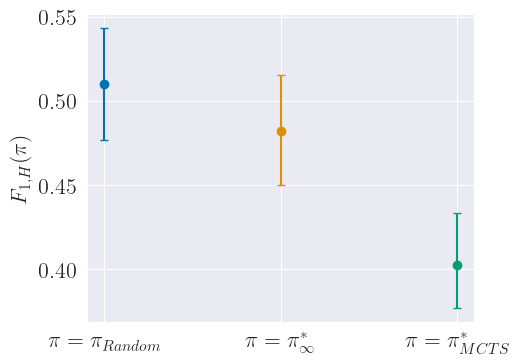

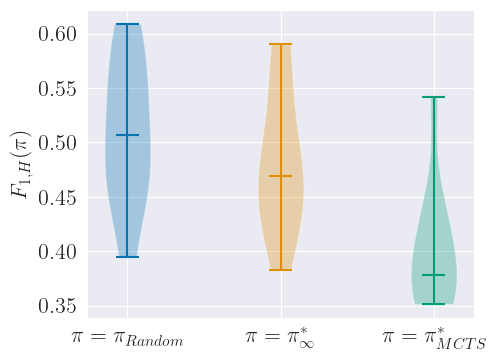

In [15]:
plot_2(data_to_plot, mdp_name=f"frozen_lake_entropy_exp_steps_{exp_steps[exp_idx_to_plot]}")
plot_3(data_to_plot, mdp_name=f"frozen_lake_entropy_exp_steps_{exp_steps[exp_idx_to_plot]}")

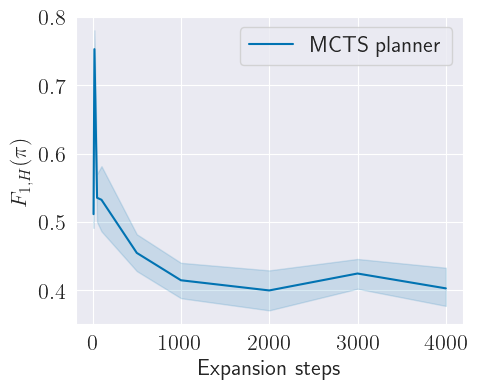

In [16]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data_entropy(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/frozen_lake_entropy.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Taxi environment

In [16]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['taxi_entropy_mcts_gamma_0.9_2025-04-23-09-48-36', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-09-48-43', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-09-48-57', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-09-49-51', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-09-51-57', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-10-03-05', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-10-25-39', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-11-12-01', 'taxi_entropy_mcts_gamma_0.9_2025-04-23-12-22-10'] 
    
env, obj_f = get_gym_env("taxi_entropy")
print("env.num_actions", env.num_actions)
print("env.num_states", env.num_states)

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
data_to_plot = {}
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_entropy(env, obj_f, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective_entropy(env, obj_f, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data_entropy(env, mcts_data_path)
# print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

env.num_actions 6
env.num_states 500
N 10
Max. traj. length: 200
Gamma: 0.9
Building transition matrix and initial states distribution...
P_matrix.shape (6, 500, 500)
p_0.shape (500,)
N 10
Max. traj. length: 200
Gamma: 0.9
Random policy: [0.65872969 0.64865211 0.64684402 0.65886644 0.64239362 0.6595376
 0.62435951 0.63178682 0.62937638 0.66787272]
Infinite trials policy: [0.60520472 0.64090149 0.62226633 0.64472282 0.6305117  0.64185272
 0.62215835 0.65930132 0.67935333 0.62230684]
MCTS planner: [0.59444379 0.59472497 0.59439266 0.59585921 0.59419577 0.59463114
 0.5941612  0.5953357  0.59427981 0.59450504]


pi_rand 0.6468418902076112 ci_low: 0.0073762310261152875 ci_up: 0.00718565011003891
pi_infinity 0.6368579617782326 ci_low: 0.010202992475701556 ci_up: 0.010806118878294857
pi_mcts 0.594652929964782 ci_low: 0.00024650730128750187 ci_up: 0.0002899113022133415


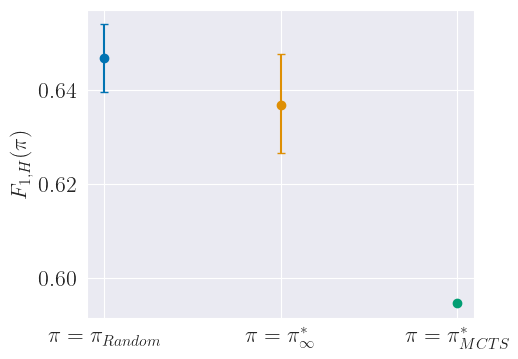

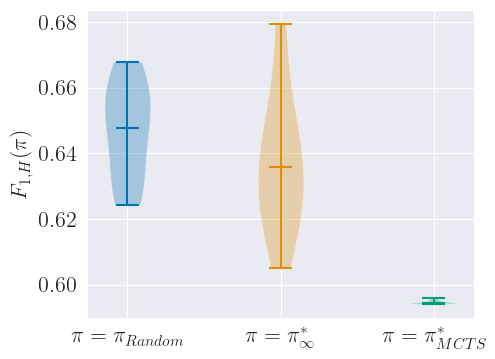

In [17]:
plot_2(data_to_plot, mdp_name=f"taxi_entropy_exp_steps_{exp_steps[exp_idx_to_plot]}")
plot_3(data_to_plot, mdp_name=f"taxi_entropy_exp_steps_{exp_steps[exp_idx_to_plot]}")

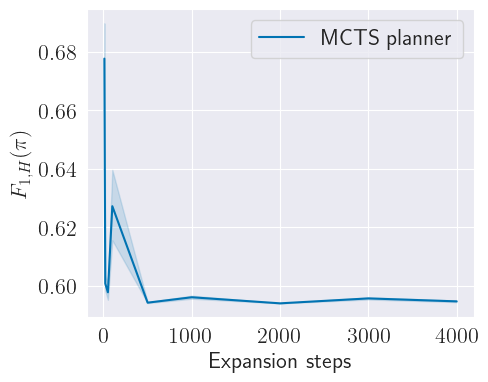

In [18]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data_entropy(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/taxi_entropy.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Imitation learning

#### The objective function is $f(d) = \| d - d_\beta\|_2^2, \quad d_\beta \in \Delta(\mathcal{S} \times \mathcal{A})$

In [12]:
import gurobipy as gp
from gurobipy import GRB

def solve_gurobi_opt_problem_imitation_learning(env, gamma, d_beta):

    nS = env.num_states
    nA = env.num_actions

    print('Building transition matrix and initial states distribution...')
    P_matrix = build_transition_matrix(env)
    p_0 = build_initial_states_distribution(env)
    print("P_matrix.shape", P_matrix.shape)
    print("p_0.shape", p_0.shape)
    
    with gp.Env(params=GUROBI_OPTIONS) as guroby_env, gp.Model(env=guroby_env) as m:
    
        x = m.addVars(nS, nA, lb=0.0, name="x")
    
        for s in range(nS):
            lhs = gp.quicksum(x[s, a] for a in range(nA))
            
            rhs = (1 - gamma) * p_0[s]
            
            for a in range(nA):
                rhs += gamma * gp.quicksum(P_matrix[a][s_prime, s] * x[s_prime, a] for s_prime in range(nS))
            
            m.addConstr(lhs == rhs, name=f"flow_state_{s}")
    
        quad_expr = gp.QuadExpr()
        for s in range(nS):
            for a in range(nA):
                quad_expr.add(x[s, a] * x[s, a] - 2 * d_beta[s, a] * x[s, a])    
            
        # Set the objective. Change GRB.MAXIMIZE to GRB.MINIMIZE if needed.
        m.setObjective(quad_expr, GRB.MINIMIZE)
        
        m.optimize()

        # Check if the optimization succeeded.
        if m.status != GRB.OPTIMAL:
            raise Exception("Model did not solve optimally.")
    
        # Extract the solution.
        x_opt = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                x_opt[s, a] = x[s, a].X

        obj_val = m.ObjVal

    opt_policy = x_opt / np.sum(x_opt, axis=1, keepdims=True)

    # row_sum = np.sum(x_opt, axis=1, keepdims=True)
    # opt_policy = np.divide(x_opt, row_sum, out=np.zeros_like(x_opt), where=row_sum != 0)
    
    return obj_val, opt_policy

In [13]:
def compute_infinite_trials_objective_imitation_learning(env, obj_f, d_beta, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)
    
    x_star, opt_policy_infinite_trials = solve_gurobi_opt_problem_imitation_learning(env, gamma, d_beta)
    # print("np.sum(opt_policy_infinite_trials)", np.sum(opt_policy_infinite_trials))
    # print("opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)]", opt_policy_infinite_trials[np.where(opt_policy_infinite_trials < 0.0)])
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, opt_policy_infinite_trials,
                                                            N=N, K=K, max_traj_length=max_traj_length, flatten=False)

    return np.array(infinite_trials_f_estimated) # [N,H]

In [14]:
def compute_random_policy_objective_imitation_learning(env, obj_f, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = mcts_plan_data["config"]["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)

    # Compute random policy finite trials objective value.
    random_policy = construct_random_policy(nS=env.num_states, nA=env.num_actions)
    random_policy_f_estimated = estimate_f_d_pi_from_samples(env, obj_f, gamma, random_policy,
                                                             N=N, K=K, max_traj_length=max_traj_length, flatten=False)

    return np.array(random_policy_f_estimated) # [N,H]

In [15]:
def load_mcts_data_imitation_learning(mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    return np.array(mcts_plan_data["f_vals"]) # [N]

#### FrozenLake environment

In [ ]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-04-01', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-04-05', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-04-13', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-04-36', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-05-24', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-09-51', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-19-01', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-11-38-06', 'frozen_lake_imitation_learning_mcts_gamma_0.9_2025-04-23-12-07-30']

env, obj_f = get_gym_env("frozen_lake_imitation_learning")

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
data_to_plot = {}
# Load distribution to imitate.
with open("data/" + FROZEN_LAKE_D_BETA + "/train_data.json", 'r') as f:
    ql_data = json.load(f)
    ql_data = json.loads(ql_data)
f.close()
imitation_learning_d_beta = np.array(ql_data["estimated_d_pi"])
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_imitation_learning(env, obj_f, imitation_learning_d_beta, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective_imitation_learning(env, obj_f, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data_imitation_learning(mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

pi_rand 0.06924162764955254 ci_low: 0.017527648921432007 ci_up: 0.017739589449646487
pi_infinity 0.05499093440000463 ci_low: 0.019035275528744164 ci_up: 0.021118596399340425
pi_mcts 0.020378163131621774 ci_low: 0.004782789520657466 ci_up: 0.005602909677335354


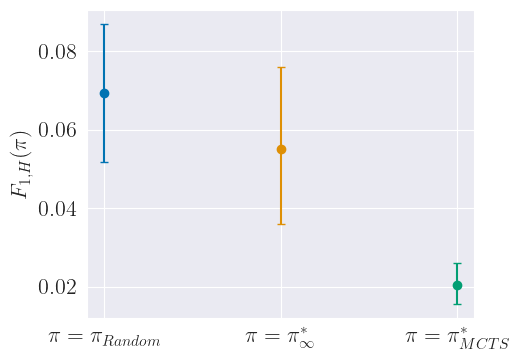

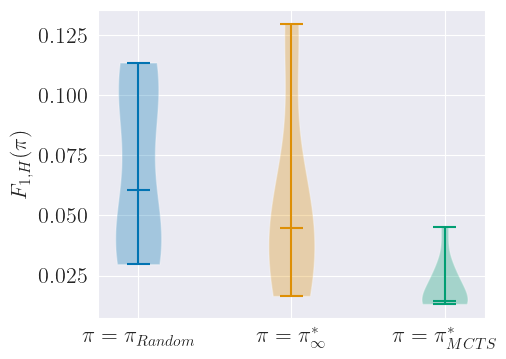

In [28]:
plot_2(data_to_plot, mdp_name=f"frozen_lake_imitation_learning_exp_steps_{exp_steps[exp_idx_to_plot]}")
plot_3(data_to_plot, mdp_name=f"frozen_lake_imitation_learning_exp_steps_{exp_steps[exp_idx_to_plot]}")

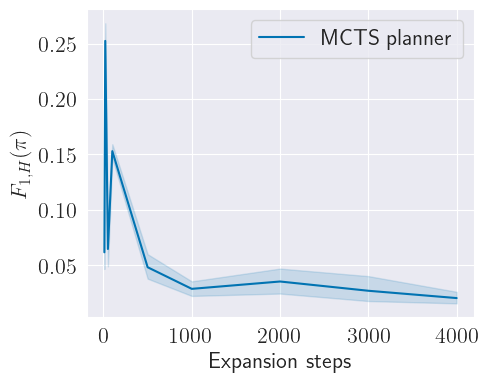

In [29]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data_imitation_learning(mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/frozen_lake_imitation_learning.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Taxi environment

In [ ]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-09-49-07', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-09-49-20', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-09-49-46', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-09-50-51', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-09-53-04', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-10-04-29', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-10-28-03', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-11-16-21', 'taxi_imitation_learning_mcts_gamma_0.9_2025-04-23-16-25-40']

env, obj_f = get_gym_env("taxi_imitation_learning")
print("env.num_states", env.num_states)
print("env.num_actions", env.num_actions)

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
data_to_plot = {}
# Load distribution to imitate.
with open("data/" + TAXI_D_BETA + "/train_data.json", 'r') as f:
    ql_data = json.load(f)
    ql_data = json.loads(ql_data)
f.close()
imitation_learning_d_beta = np.array(ql_data["estimated_d_pi"])
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_imitation_learning(env, obj_f, imitation_learning_d_beta, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective_imitation_learning(env, obj_f, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data_imitation_learning(mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

pi_rand 0.07870989214573368 ci_low: 0.008561240053501853 ci_up: 0.00941289987880653
pi_infinity 0.04747365101127109 ci_low: 0.0014282957274079494 ci_up: 0.001653585698968743
pi_mcts 0.04894488907229949 ci_low: 0.002217993120240999 ci_up: 0.002301067004231931


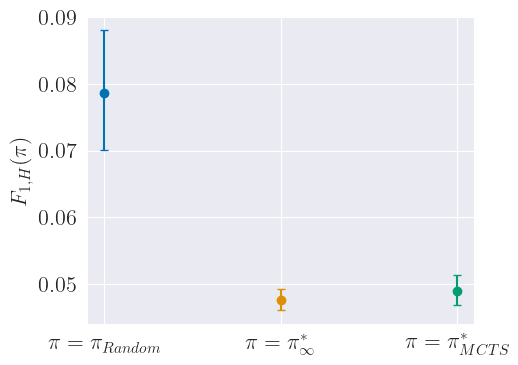

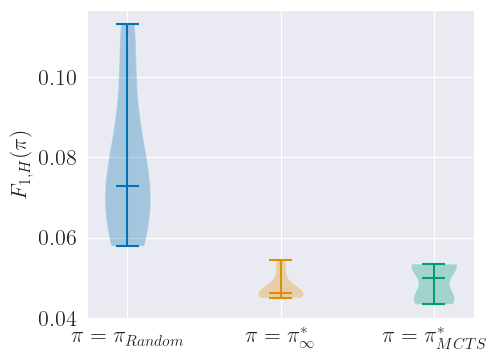

In [17]:
plot_2(data_to_plot, mdp_name=f"taxi_imitation_learning_exp_steps_{exp_steps[exp_idx_to_plot]}")
plot_3(data_to_plot, mdp_name=f"taxi_imitation_learning_exp_steps_{exp_steps[exp_idx_to_plot]}")

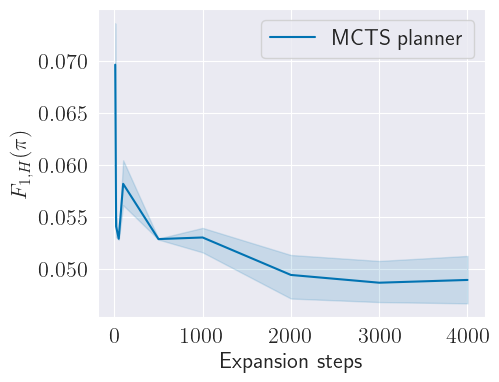

In [18]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data_imitation_learning(mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/taxi_imitation_learning.pdf', bbox_inches='tight', pad_inches=0)
plt.show()